# Sentiment Analysis project: hate speech detection
## Creation of a dictionary of the bully language 
#### Martina Corsini, ID 944506
#### Camilla Gotta, ID 945522
#### Dse 2020/2021

### Dataset
Bully Messages Detection dataset:
https://www.kaggle.com/imranzaman5202/bully-messages-detection

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#import tools and libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
import nltk
import random
import re
import string
!python -m spacy download en_core_web_sm
import spacy
from spacy.lang.en import English
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import skipgrams
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -U gensim
import gensim
from gensim import corpora
import pickle
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import operator
import statistics

2021-06-02 16:11:54.736598: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-02 16:11:54.736648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Requirement already up-to-date: gensim in c:\users\dell\anaconda3\lib\site-packages (4.0.1)


C:\Users\DELL\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#Loading CSV file
initial_dataset = pd.read_csv(r"C:\Users\DELL\Downloads\Bully Messages dataset.csv",sep=",") 

In [5]:
#rename columns
initial_dataset.columns = ["text", "target"]

In [6]:
#encode categories: "normal_text"=1, "bully_or_abusive_text"=0
initial_dataset['target'] = np.where(initial_dataset['target']=='Normal_text',1,0)

## Performing topic model (LDA)

Topic model is an unsupervised machine learning method that helps discover hidden semantic structures in a paper, that allows to learn topic representations of papers in a corpus.

The model can be applied to any kinds of labels on documents, such as tags on posts on the website.

The clusters of similar words are called topics. We choose the number of topics at the beginning of our process.

Here we use Latent Dirichlet Allocation (LDA), one of the most popular topic modeling methods: is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

In [7]:
#clean the text
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"(-script\.pyw?|\.exe)?$^\d+\s|\s\d+\s|\s\d+$".format(string.punctuation), " ", line)
    return line

In [8]:
#tokenize the text
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('')
        elif token.orth_.startswith('@'):
            lda_tokens.append('')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [9]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma


In [10]:
#filter out stop words
en_stop = set(nltk.corpus.stopwords.words('english'))

In [11]:
#define a function to prepare the text for topic modelling
def clean_text_for_lda(text):                                        
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [12]:
#Create Bullydf_text.csv
Bullydf= initial_dataset.loc[(initial_dataset['target'] == 0)]
Bullydf_text = Bullydf[['text']] 
#Bullydf_text.to_csv(r"C:\Users\DELL\data\Bullydf_text.csv", header=False, index = False)

In [13]:
#import dataset prepared for LDA
clean_data_for_LDA=[]
with open(r"C:\Users\DELL\data\Bullydf_text.csv",encoding="utf8") as f:
    for line in f:
        word= preprocessing(line)
        tokens = clean_text_for_lda(word)
        clean_data_for_LDA.append(tokens)        

### Skipgrams
The skipgrams of a sentence $w_{i1},..., w_{im}$ can be described as ${ w_{i1}, w_{i2},…, w_{in}|\sum\limits_{j=1}^n=i_{j}- i_{j-1} <k}$ where parameter k refers to the max skip-distance and n to the “grams” or subsequence length. We set k equal to the length of the sentence and n equal to 2.

In [14]:
#create skipgrams 
str_per_skipgram = []
for i in clean_data_for_LDA:
    a= " ".join (i)
    str_per_skipgram.append (a)
str_per_skipgram


list_of_skipgrams =[]
for i in str_per_skipgram:
    sent = i.split()
    a = list(skipgrams(sent, 2, len (i)))
    list_of_skipgrams.append (a)
list_of_skipgrams

list_k = []
for i in list_of_skipgrams:
    a = list("_".join(a) for a in i)
    list_k.append (a)

### Retrieving LDA words-weights

In [15]:
data_for_LDA= []
for i in range (427):
    a= clean_data_for_LDA[i]+ list_k[i]
    data_for_LDA.append (a)

In [16]:
dictionary = corpora.Dictionary(data_for_LDA)

In [17]:
corpus = [dictionary.doc2bow(text) for text in data_for_LDA]

In [18]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [19]:
#For each of the chosen 3 topic, we will explore the words occuring in that topic and their relative weights
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=20)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("\n")

(0, '0.002*"goatfucker" + 0.002*"shit" + 0.002*"fucking" + 0.001*"retard" + 0.001*"fuck" + 0.001*"..." + 0.001*"low" + 0.001*"like" + 0.001*"idiot" + 0.001*"one" + 0.001*"n\'t" + 0.001*"piece" + 0.001*"piece_shit" + 0.001*"asshole" + 0.001*"cunt" + 0.001*"worthless" + 0.001*"ass" + 0.001*"nobody" + 0.001*"fugly" + 0.001*"bitch" + 0.001*"care" + 0.001*"ky" + 0.001*".realdonaldtrump" + 0.001*"know" + 0.001*"loser" + 0.001*"fucking_fucking" + 0.001*"dumbass" + 0.001*"pathetic" + 0.001*"nobody_care" + 0.001*"nazi"')


(1, '0.003*"low" + 0.001*"idiot" + 0.001*"fuck" + 0.001*"fugly" + 0.001*"say" + 0.001*"like" + 0.001*"dumbass" + 0.001*"get" + 0.001*"goatfucker" + 0.001*"realdonaldtrump" + 0.001*"fucking" + 0.001*"retard" + 0.001*"\'re" + 0.001*"know" + 0.001*"don?t" + 0.001*"shit" + 0.001*"asshole" + 0.001*"cunt" + 0.001*"would" + 0.001*"n\'t" + 0.001*"bitch" + 0.001*"dumb" + 0.001*"stupid" + 0.001*"people" + 0.001*"guess" + 0.001*"fag" + 0.001*"still" + 0.001*"good" + 0.001*"don?t_nazi" +

In [20]:
lda = gensim.models.ldamodel.LdaModel.load('model3.gensim')
words_for_topic = lda.show_topics(num_topics=3, num_words=30, log=False, formatted=False)

In [21]:
list_of_words = []
for i in words_for_topic:
    y= i[1]
    list_of_words.append(y)
list_of_tuples= []
for i in list_of_words:
    for tupla in i:
        list_of_tuples.append(tupla)

In [22]:
LDA_dict = dict()
for t in list_of_tuples:
    if t [0] in LDA_dict.keys():
        LDA_dict [t [0]].append(t [1])
        
    else:
        LDA_dict.update({t [0]: [t [1]]}) 

In [23]:
keys_of_LDA = []
for x in LDA_dict.keys():
    keys_of_LDA.append(x)

In [24]:
values_of_LDA = []
for x in LDA_dict.values():
    a =sum (x)
    values_of_LDA.append(a)

In [25]:
final_dict_LDA = {}
for key in keys_of_LDA:
    for value in values_of_LDA:
        final_dict_LDA[key] = value
        values_of_LDA.remove(value)
        break  

### Normalized LDA words

In [26]:
dfLDA = pd.DataFrame.from_dict(final_dict_LDA, orient='index', columns=['weights_LDA'])

In [27]:
x_array_LDA = np.array(dfLDA['weights_LDA']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(x_array_LDA)
normalized_X_LDA = scaler.transform(x_array_LDA)
dfLDA['min max'] = normalized_X_LDA.reshape(1,-1)[0]

In [28]:
wrong_list_LDA = normalized_X_LDA.tolist()
normalized_weights_LDA =[]
for x in wrong_list_LDA:
    for list in x:
        normalized_weights_LDA.append(list)

In [29]:
final_dict_LDA_normalized = {}
for key in keys_of_LDA:
    for value in normalized_weights_LDA:
        final_dict_LDA_normalized[key] = value
        normalized_weights_LDA.remove(value)
        break
print ("Resultant dictionary is : " + str(final_dict_LDA_normalized))

Resultant dictionary is : {'goatfucker': 0.6455068221844313, 'shit': 0.5667691531901065, 'fucking': 0.6469252908111036, 'retard': 0.3352857740494195, 'fuck': 0.7902545846997573, '...': 0.319856007059974, 'low': 0.9999999999999998, 'like': 0.5629627058723308, 'idiot': 0.36657216254122565, 'one': 0.19215192649164953, "n't": 0.20658460468019824, 'piece': 0.2672085869372847, 'piece_shit': 0.26720700155913385, 'asshole': 0.2065934098020144, 'cunt': 0.1897545723988196, 'worthless': 0.1926451729917305, 'ass': 0.054155320044906585, 'nobody': 0.19245702624369976, 'fugly': 0.29769112027302536, 'bitch': 0.3463936177101019, 'care': 0.15566416321009557, 'ky': 0.03321252029469374, '.realdonaldtrump': 0.018504031930291542, 'know': 0.17419459910023743, 'loser': 0.018422082707170745, 'fucking_fucking': 0.01842087371376075, 'dumbass': 0.3946498825229087, 'pathetic': 0.01835878163711918, 'nobody_care': 0.01821435254701778, 'nazi': 0.017918616791095854, 'say': 0.12796204098298328, 'get': 0.281994701803087

### Most relevant words with Spacy (LDA)

In order to construct the dictionary based on LDA words, only nouns, adjectives and verbs are selecting to be part of the dictionary from the normalized words. We use Spacy to perform this task.

In [30]:
nlp = spacy.load("en_core_web_sm")

In [31]:
LDA_normalized_values= []
for i in final_dict_LDA_normalized:
        LDA_normalized_values.append(i)
Str_LDA = " ".join(LDA_normalized_values)
doc = nlp(Str_LDA)
LDAword=[]
for token in doc:
    if  token.pos_ == "NOUN":
        LDAword.append(token)
    elif token.pos_ == "ADJ":
        LDAword.append(token)
    elif token.pos_== "VERB":
        LDAword.append(token)

In [32]:
#matching relevant words with respective weights
LDAword_string_keys = []    
for i in LDAword:
    LDAword_string_keys.append(i.text)
LDAword_string_values = []
for key in LDAword_string_keys:
    LDAword_string_values.append(final_dict_LDA_normalized[key])

In [33]:
df_LDA = pd.DataFrame(zip(LDAword_string_keys,LDAword_string_values), columns = ['LDAWords','Normalization']).set_index(['LDAWords'])
df_LDA

,Normalization
LDAWords,
goatfucker,0.645507
shit,0.566769
fucking,0.646925
retard,0.335286
fuck,0.790255
idiot,0.366572
piece,0.267209
piece_shit,0.267207
asshole,0.206593


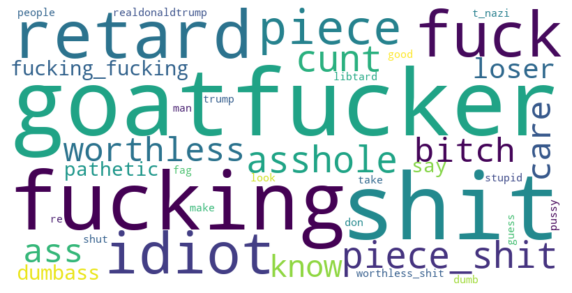

In [34]:
comment_words = ' '
stopwords_wordcloud = set(STOPWORDS) 
text = LDAword 
wc = WordCloud(background_color='white', width=800, height=400, max_words=200,stopwords = stopwords_wordcloud).generate(str(text).replace("'",""))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Performing classifications
Supervised methods aimed to assign the correct label to the given input (terms)

In [35]:
#split the sample in training set and test set
X = initial_dataset[['text']]
y = initial_dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self, lang = "english"):
        self.lang = lang
    
    def fit( self, X, y = None ):
        return self 
   

    def clean( self, x ):
        words   = [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
        return " ".join(words)
    
    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [37]:
class CustomFeatures( BaseEstimator, TransformerMixin ):
     
    def __init__( self ):
        return
      
    def fit( self, X, y = None ):
        return self 
        
    def transform( self, X, y = None ):
        f           = pd.DataFrame()
        f['len']    = X['text'].str.len()
        f['digits'] = X['text'].str.findall(r'\d').str.len()
        f['punct']  = X['text'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
        return f[['len','digits','punct']]

### Random Forest

Random forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier.

In [38]:
pipe_random_forest = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()),
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2)),
                 ("scale", StandardScaler(with_mean = False)),
                 ("classify", RandomForestClassifier(n_estimators=500)
                 )])

pipe_random_forest.fit(X_train, y_train)
y_pred = pipe_random_forest.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      0.53      0.52        76
           1       0.74      0.73      0.73       137

    accuracy                           0.66       213
   macro avg       0.63      0.63      0.63       213
weighted avg       0.66      0.66      0.66       213



### Logistic Regression
We must consider $P(y^∗ = 0|x^∗)$ and $P(y^* = 1|x^*)$ and we must select the label corresponding to the class with the higher P.

In [39]:
pipe_logistic = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                                ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2, k = 1000)),
                 ("scale", StandardScaler(with_mean = False)),
                 ("classify", LogisticRegression())]) 

pipe_logistic.fit(X_train, y_train)
y_pred = pipe_logistic.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.58      0.61      0.59        76
           1       0.78      0.76      0.77       137

    accuracy                           0.70       213
   macro avg       0.68      0.68      0.68       213
weighted avg       0.71      0.70      0.71       213



### Multinomial Naive Bayes
The Naive Bayes algorithms classify a document with terms with the class that is most likely, given the corresponding set of features (assuming independence). Multinomial naive Bayes: feature vectors represent the frequencies with which certain terms have been generated by a multinomial with parameters $(p_ {1,c},…,p_{i,c},…)$ where $p_{i,c}$ is the probability that term $d_i$ occurs in class $c$.

In [40]:
pipe_multinomial = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                                ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2, k = 1000)),
                 ("scale", StandardScaler(with_mean = False)),
                 ("classify", MultinomialNB

())]) 

pipe_multinomial.fit(X_train, y_train)
y_pred = pipe_multinomial.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48        76
           1       0.72      0.83      0.77       137

    accuracy                           0.68       213
   macro avg       0.65      0.62      0.62       213
weighted avg       0.67      0.68      0.67       213



### Bernoulli Naive Bayes
Bernoulli naive Bayes: features are binary variables (term is present / absent). It's useful for classifying short texts

In [41]:
pipe_Bernoulli = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                                ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2, k = 1000)),
                 ("scale", StandardScaler(with_mean = False)),
                 ("classify", BernoulliNB

())]) 

pipe_Bernoulli.fit(X_train, y_train)
y_pred = pipe_Bernoulli.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.17      0.28        76
           1       0.68      0.97      0.80       137

    accuracy                           0.69       213
   macro avg       0.72      0.57      0.54       213
weighted avg       0.71      0.69      0.61       213



### Complement Naive Bayes
Complement naive Bayes: is an adaptation of the standard Multinomial Naive Bayes algorithm that is particularly suited for imbalanced data sets.

In [42]:
pipe_complement = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                                ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2, k = 1000)),
                 ("scale", StandardScaler(with_mean = False)),
                 ("classify", ComplementNB

())]) 

pipe_complement.fit(X_train, y_train)
y_pred = pipe_complement.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.41      0.48        76
           1       0.72      0.83      0.77       137

    accuracy                           0.68       213
   macro avg       0.65      0.62      0.62       213
weighted avg       0.67      0.68      0.67       213



In order to evaluate the performance of the model, retrieve a few metrics. In detail:

Accuracy: $$Acc= \frac{TP + TN}{TP + FP + TN + FN}$$

Precision: $$Prec= \frac{TP}{TP + FP}$$

Recall: $$Rec= \frac{TP}{TP + FN}$$

F1: $$F_1= 2\cdot\frac{Prec \cdot Rec}{Prec + Rec}$$


Logistic Regression performs better than the other classifiers.

## Performing LIME

This section is about explaining what machine learning classifiers (or models) are doing. The classifier used in the section is the one with the highest performance (tested before)

Lime is able to explain individual predictions for text classifiers, any black box with two or more classes: what it requires is that the classifier implements a function that takes in raw text and outputs a probability for each class. 

In [43]:
df_train, df_test = train_test_split(initial_dataset, test_size=0.2, random_state=42)
#df_train.to_csv(r"C:\Users\DELL\data\df_train.csv")
#df_test.to_csv(r"C:\Users\DELL\data\df_test.csv")

In [44]:
reviews_train = pd.read_csv(r"C:\Users\DELL\data\df_train.csv")
reviews_test = pd.read_csv(r"C:\Users\DELL\data\df_test.csv")

In [45]:
#rename train
reviews_train = reviews_train.drop(['Unnamed: 0'], axis = 1)
#rename test
reviews_test = reviews_test.drop(['Unnamed: 0'], axis = 1)

### Vectorization

In [46]:
cv = CountVectorizer(binary= True,stop_words='english')
cv.fit(reviews_train.text)
X = cv.transform(reviews_train.text)
X_test = cv.transform(reviews_test.text)

### Build a predictive model

In [47]:
# with logistic regression
X_train, X_val, y_train, y_val = train_test_split(X, reviews_train.target, train_size = 0.8, random_state= 42)
pipe_logistic = LogisticRegression() 
pipe_logistic.fit(X_train, y_train)

print ("Accuracy: %s" 
       % accuracy_score(y_val, pipe_logistic.predict(X_val)))
print ("Precision: %s" 
       % precision_score(y_val, pipe_logistic.predict(X_val)))

Accuracy: 0.7485380116959064
Precision: 0.7787610619469026


### Explain prediction with LIME

In [48]:
c = make_pipeline(cv, pipe_logistic)

In [49]:
explainer = LimeTextExplainer(class_names=[0,1],bow= False)

### Understanding how reviews are classified

In [50]:
#example
idx =30
exp = explainer.explain_instance(reviews_test.text[idx], c.predict_proba, num_features=8)
print('True class: %s' % reviews_test.target[idx])
exp.show_in_notebook(text=True)

True class: 0


In [51]:
#check if false positive/false negative
for a,b in c.predict_proba([reviews_test.text[idx]]):
    if a < b:
        x= 1
    else:
        x = 0 
if x == reviews_test.target[idx]: 
    print ("ok")
else:
    print ("false positive/negative")

ok


### Retrieving LIME words-weights

In [52]:
list_of_tuples_LIME= []
for x in range (213):
    idx = x
    exp = explainer.explain_instance(reviews_test.text[idx], c.predict_proba, num_features=8)
    exp.as_list()
    list_of_tuples_LIME.extend(exp.as_list())

In [53]:
list_of_tuples_LIME

[('amp', 0.1164510499818342),
 ('fe', -0.06535998548525572),
 ('check', -0.044864355358743446),
 ('regular', -0.03897494372659183),
 ('lives', 0.0370219878994126),
 ('cool', 0.03062930098566104),
 ('perfect', 0.011817945691995324),
 ('everyone', -0.0005782381769758083),
 ('fuck', -0.20942603811870877),
 ('dumb', -0.06291609646518442),
 ('to', 0.00023132838013844133),
 ('Go', 0.0001543367249040743),
 ('you', 0.00013105963327237578),
 ('back', 0.00011864338100380439),
 ('cows', 0.00011822771763025236),
 ('worshipping', 4.4425183656848405e-05),
 ('Day', 0.030711205888966926),
 ('Day', 0.030573804721470706),
 ('Happy', 0.024837292816716715),
 ('Happy', 0.024583470261957528),
 ('MINGYU', 0.0026896977324046595),
 ('SEVENTEEN', 0.0022236285172045705),
 ('s', 0.0017762232268544074),
 ('MINGYU', 0.0016376460717056724),
 ('libtard', -0.285853379267402),
 ('dirty', 0.06656586914277626),
 ('Wait', 0.03311605472659431),
 ('saying', 0.023406418790892138),
 ('a', -0.0004846770918846064),
 ('a', -0.00

In [54]:
LIME_dict = dict()
[LIME_dict[t[0]].append(t[1]) if t[0] in LIME_dict.keys() 
 else LIME_dict.update({t[0]:[t[1]]}) for t in list_of_tuples_LIME]
LIME_dict 

{'amp': [0.1164510499818342,
  0.12511736721569666,
  0.10092760634635937,
  0.09211606225251553,
  0.10224368627824315,
  0.07856510333873484,
  0.11147159718720832],
 'fe': [-0.06535998548525572],
 'check': [-0.044864355358743446],
 'regular': [-0.03897494372659183],
 'lives': [0.0370219878994126],
 'cool': [0.03062930098566104],
 'perfect': [0.011817945691995324, 0.012937541610799306],
 'everyone': [-0.0005782381769758083],
 'fuck': [-0.20942603811870877,
  -0.1985806227084749,
  -0.21149131455528675,
  -0.2111779800242316,
  -0.2034401401907045,
  -0.16928090709912597,
  -0.19591964912459925,
  -0.1984346987549051,
  -0.20596980282242106],
 'dumb': [-0.06291609646518442, -0.05993616997378348],
 'to': [0.00023132838013844133,
  0.0,
  -0.00013633084238691596,
  0.00023111548136373294,
  -0.00029358391170837984,
  -0.00023568468048698753,
  0.00022759503201380342,
  6.617148681270852e-06,
  0.0002967880860489899,
  -0.0007048043964452378],
 'Go': [0.0001543367249040743],
 'you': [0.0

In [55]:
keys_of_LIME = []
for x in LIME_dict.keys():
    keys_of_LIME.append(x)

In [56]:
values_of_LIME = []
for x in LIME_dict.values():
    a =sum (x)
    values_of_LIME.append(a)

In [57]:
final_dict_LIME = {}
for key in keys_of_LIME:
    for value in values_of_LIME:
        final_dict_LIME[key] = value
        values_of_LIME.remove(value)
        break  

In [58]:
sortedDict = sorted(final_dict_LIME.items(), key=operator.itemgetter(1))

### Normalized LIME (negative) words

In [59]:
#taking only the words with a negative weight
Lime_negative= []
for i in sortedDict:
    if i[1]< 0:
        Lime_negative.append(i)

In [60]:
LIME_dict = dict(Lime_negative)

In [61]:
#taking absolute values for the normalization
abs_dict={}
abs_list=[]
for i in LIME_dict.values():
    absolute = abs(i)
    abs_list.append(absolute)    
for key in LIME_dict:
    for value in abs_list:
        abs_dict[key] = value
        abs_list.remove(value)
        break

In [62]:
dfLIME = pd.DataFrame.from_dict(abs_dict, orient= 'index', columns=['weights_LIME'])

In [63]:
x_array_LIME = np.array(dfLIME['weights_LIME']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(x_array_LIME)
normalized_X_LIME = scaler.transform(x_array_LIME)
dfLIME['min max'] = normalized_X_LIME.reshape(1,-1)[0]

In [64]:
wrong_list_LIME = normalized_X_LIME.tolist()
normalized_weights_LIME =[]
for x in wrong_list_LIME:
    for list in x:
        normalized_weights_LIME.append(list)

In [65]:
final_dict_LIME_normalized = {}
for key in LIME_dict:
    for value in normalized_weights_LIME:
        final_dict_LIME_normalized[key] = value
        normalized_weights_LIME.remove(value)
        break
print ("Resultant dictionary is : " + str(final_dict_LIME_normalized))

Resultant dictionary is : {'goatfucker': 1.0, 'IQ': 0.5596528860410566, 'realDonaldTrump': 0.47275408438796074, 'low': 0.4274162264542913, 'idiot': 0.4153024113118789, 'fuck': 0.3597261026270094, 'retard': 0.32928661754402616, 'libtard': 0.2975831572178073, 'asshole': 0.29611983670697134, 'pussy': 0.2885455909321622, 'fucking': 0.28134911816258795, 'fag': 0.269235481407314, 'cunt': 0.2664920477158922, 'pathetic': 0.21199520061999785, 'cares': 0.1515477745246972, 'bitch': 0.14736379514290518, 'want': 0.14336435768936165, 'Nazi': 0.13972802102532406, 'piece': 0.1258682342051374, 'shit': 0.12090733216077545, 'Low': 0.1195590594293396, 'doing': 0.11194679462404464, 'say': 0.10898673406416008, 'DLoesch': 0.09058159912598937, 'little': 0.08651199047824766, 'ur': 0.08034940884287407, 'worthless': 0.0782165921227137, 'stupid': 0.07419904966059826, 'iq': 0.07062392814416132, 'Trump': 0.06604067540495444, 'FUCKING': 0.06341850673943497, 'life': 0.06066934122164373, 'LIBTARD': 0.06003451140502865

### Most relevant words with Spacy (Lime)

In order to construct the dictionary based on LIME words, only nouns, adjectives and verbs are selected to be part of the dictionary from the normalized words.

In [66]:
LIME_normalized_values= []
for i in final_dict_LIME_normalized:
        LIME_normalized_values.append(i)

In [67]:
LIMEStr = " ".join(LIME_normalized_values)
doc = nlp(LIMEStr)
LIMEword=[]
for token in doc:
    if  token.pos_ == "NOUN":
        LIMEword.append(token)
    elif token.pos_ == "ADJ":
        LIMEword.append(token)
    elif token.pos_== "VERB":
        LIMEword.append(token)

In [68]:
LIMEword_string_keys = []    
for i in LIMEword:
    LIMEword_string_keys.append(i.text)
LIMEword_string_keys.remove("s")
LIMEword_string_values = []
for key in LIMEword_string_keys:
    LIMEword_string_values.append(final_dict_LIME_normalized[key])

In [69]:
df_LIME = pd.DataFrame(zip(LIMEword_string_keys,LIMEword_string_values), columns = ['LIMEWords','Normalization_lime']).set_index(['LIMEWords'])

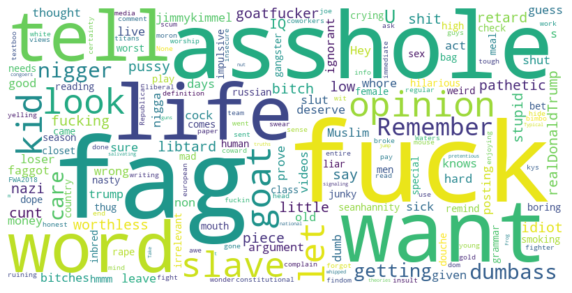

In [70]:
text = LIMEword  
wc = WordCloud(background_color='white', width=800, height=400, max_words=200,stopwords = stopwords_wordcloud).generate(str(text).replace("'",""))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data Visualization

### Scatterplot

In [71]:
#union of the two dictionaries
df_matching = pd.merge(left= df_LDA.T, right= df_LIME.T, how= 'outer') 

In [72]:
 #replace NaN values with 0
df_non_null = df_matching.T.fillna(0)

In [73]:
df_union = df_non_null.rename(columns={0: 'LDA', 1:'LIME'})

In [74]:
df_union_text= df_union.index.values
df_union.insert( 0, column="TEXT", value = df_union_text)

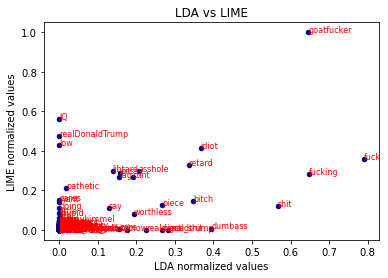

In [75]:
ax1 = df_union.plot.scatter(x='LDA', y='LIME', c='DarkBlue') #plotting the normalized values of the two techniques
for i in range(df_union.shape[0]):
    plt.text(x=df_union.LDA[i],y=df_union.LIME[i], s=df_union.TEXT[i],
          fontdict=dict(color='red',size=8))
plt.title("LDA vs LIME") #title
plt.xlabel("LDA normalized values") #x label
plt.ylabel("LIME normalized values")  #y label
plt.show()

## Creation of final dictionaries

### Intersection

In [76]:
#add a column for mean of LDA and LIME values if both of them exist (intersection set)
df_intersection = df_matching.T
df_intersection_text= df_intersection.index.values
df_intersection.insert( 0, column="TEXT", value = df_intersection_text)
df_intersection [[3]] = df_intersection.mean( axis=1, skipna=False)
df_intersection = df_intersection.dropna(subset=[3])
df_intersection = df_intersection.rename(columns={3: 'Mean', 0: 'LDA', 1: 'LIME'})

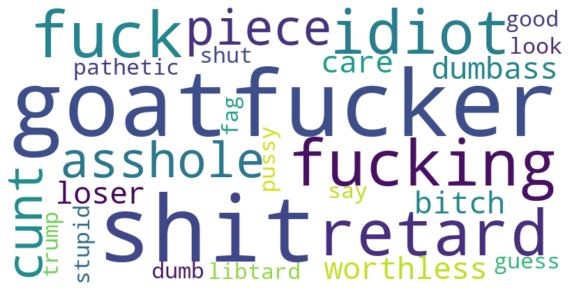

In [77]:
text = df_intersection["TEXT"].values 
wc = WordCloud(background_color='white', width=800, height=400, max_words=200,stopwords = stopwords_wordcloud).generate(str(text).replace("'",""))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [78]:
#create intersection dictionary 
for i in df_intersection.drop(columns={'LDA', 'LIME'}).T.to_dict("records"):
    dictionary_intersection = i

### Validation of intersection dictionary

In [79]:
#detect which words of the intersection dictionary appears in each tweet of the initial dataset
list_of_tuples_intersection = []
for idx in range (1065): 
    tokens = tokenize(initial_dataset.text[idx])
    for x in tokens:
        for keys in dictionary_intersection:
            if x == keys: 
                a = dictionary_intersection [keys]
                tupla = (idx, a)
                list_of_tuples_intersection.append(tupla)

In [80]:
#assign a value of offensiveness for each tweet summing the appearing values
value_dict_intersection = dict()
[value_dict_intersection[t[0]].append(t[1]) if t[0] in value_dict_intersection.keys() else value_dict_intersection.update({t[0]:[t[1]]}) for t in list_of_tuples_intersection]

weights_intersection = []
for x in value_dict_intersection.values():
    a =sum (x)
    weights_intersection.append(a)


In [81]:
#create a dictionary with tweets and weights associated
final_dict_weights_intersection = {}
for key in value_dict_intersection.keys ():
    for value in weights_intersection:
        final_dict_weights_intersection[key] = value
        weights_intersection.remove(value)
        break  
for x in range (1065):
    if x not in final_dict_weights_intersection:
        final_dict_weights_intersection[x] = 0

In [82]:
#mean of the weights of normal text
normal_dictionary_intersection = {}
for key, value in final_dict_weights_intersection.items():
    if (key < 637):
        normal_dictionary_intersection[key] = value
statistics.mean(normal_dictionary_intersection.values())

0.128579764658261

In [83]:
#mean of the weights of bully/abusive text
bully_dictionary_intersection = {}
for key, value in final_dict_weights_intersection.items():
    if (key > 637):
        bully_dictionary_intersection[key] = value
statistics.mean(bully_dictionary_intersection.values())

0.3534291644710019

In [84]:
#create the dataframe
weights_intesection = pd.DataFrame.from_dict(final_dict_weights_intersection, orient='index').rename(columns={0:'Weights'})
sorted_weights_intesection = weights_intesection.sort_index()

In [85]:
#see how tweet are labelled 
sorted_weights_intesection ["predicted_values"] = [1 if Weights == 0 else 0 for Weights in sorted_weights_intesection["Weights"]]
sorted_weights_intesection ["actual_values"]= initial_dataset['target']
sorted_weights_intesection

,Weights,predicted_values,actual_values
0,0.000000,1,1
1,0.000000,1,1
2,0.000000,1,1
3,0.118474,0,1
4,0.000000,1,1
...,...,...,...
1060,0.217773,0,0
1061,0.217773,0,0
1062,0.217773,0,0
1063,0.000000,1,0


In [86]:
#create a function for retrieving TP, FP, TN, FN, accuracy, precision, recall, F1_score, so to validate the intersection dictionary
def validation(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FN += 1
        if y_actual[i]==y_hat[i]==0:
           TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
    accuracy = (𝑇𝑃+𝑇𝑁) / (𝑇𝑃+𝐹𝑃+𝑇𝑁+𝐹𝑁)
    precision = TP / (TP + FP)
    recall = 𝑇𝑃/(𝑇𝑃+𝐹𝑁)
    F1_score = 2 * ( precision * recall )/( precision + recall)

    return(TP, FP, TN, FN, accuracy, precision, recall, F1_score)
    

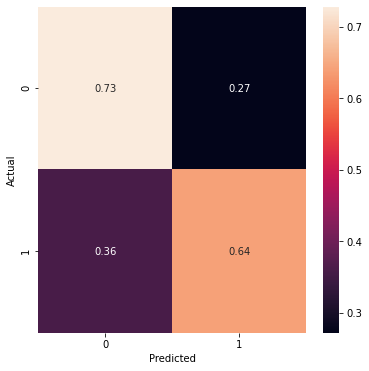

In [87]:
#confusion matrix
cm = confusion_matrix(sorted_weights_intesection["actual_values"].values, sorted_weights_intesection["predicted_values"].values)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [88]:
validation(initial_dataset['target'], sorted_weights_intesection["predicted_values"])

(311,
 229,
 409,
 116,
 0.676056338028169,
 0.575925925925926,
 0.7283372365339579,
 0.6432264736297828)

### Synonyms of intersection dictionary

In [89]:
for syn in wn.synsets("idiot"):
    for name in syn.lemma_names():
        print(name)

idiot
imbecile
cretin
moron
changeling
half-wit
retard


In [90]:
#increased dictionary with synonyms (weights from original words)
list_synonyms_intersection = []
for i in dictionary_intersection:
    for syn in wn.synsets(i): 
        for name in syn.lemma_names():
            list_synonyms_intersection.append((name, dictionary_intersection[i]))
            list_important_synonyms_intersection = []
for x in list_synonyms_intersection:
    if x[0] not in dictionary_intersection.keys():
        if x[1]> 0.5:
            list_important_synonyms_intersection.append((x[0], x[1]))
for x in list_important_synonyms_intersection:
    dictionary_intersection [x[0]] = x[1]
dictionary_intersection_syn = dictionary_intersection
dictionary_intersection_syn

{'goatfucker': 0.8227534110922157,
 'shit': 0.34383824267544094,
 'fucking': 0.4641372044868458,
 'retard': 0.3322861957967228,
 'fuck': 0.5749903436633833,
 'idiot': 0.3909372869265523,
 'piece': 0.19653841057121108,
 'asshole': 0.2513566232544929,
 'cunt': 0.2281233100573559,
 'worthless': 0.1354308825572221,
 'bitch': 0.24687870642650356,
 'care': 0.08018264463090953,
 'loser': 0.023802479429188023,
 'dumbass': 0.20084438785762182,
 'pathetic': 0.11517699112855852,
 'say': 0.11847438752357167,
 'dumb': 0.01253344952592003,
 'stupid': 0.0372803092646869,
 'guess': 0.010095384247886544,
 'fag': 0.2123757657595436,
 'good': 0.01118886906457992,
 'libtard': 0.21777309849451282,
 'pussy': 0.22297342478022722,
 'look': 0.027670334194729876,
 'trump': 0.023436274736187618,
 'shut': 0.022121075218803875,
 'screw': 0.5749903436633833,
 'screwing': 0.5749903436633833,
 'ass': 0.5749903436633833,
 'nooky': 0.5749903436633833,
 'nookie': 0.5749903436633833,
 'piece_of_ass': 0.5749903436633833,


### Union

In [91]:
#add a column for mean of LDA and LIME values
df_union [[3]] = df_union.mean( axis=1)
df_union = df_union.rename(columns={3: 'Mean'})

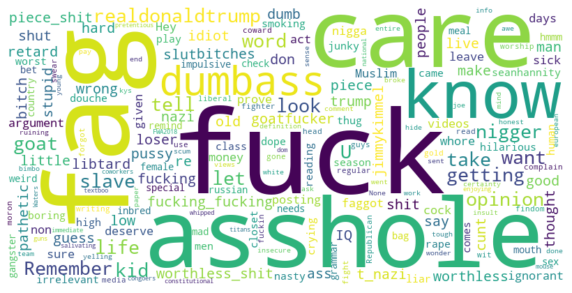

In [92]:
text = df_union['TEXT'].values 
wc = WordCloud(background_color='white', width=800, height=400, max_words=200,stopwords = stopwords_wordcloud).generate(str(text).replace("'",""))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [93]:
#create union dictionary 
for i in df_union.drop(columns={'LDA', 'LIME'}).T.to_dict("records"):
    dictionary_union = i
dictionary_union

{'goatfucker': 0.8227534110922157,
 'shit': 0.34383824267544094,
 'fucking': 0.4641372044868458,
 'retard': 0.3322861957967228,
 'fuck': 0.5749903436633833,
 'idiot': 0.3909372869265523,
 'piece': 0.19653841057121108,
 'piece_shit': 0.13360350077956692,
 'asshole': 0.2513566232544929,
 'cunt': 0.2281233100573559,
 'worthless': 0.1354308825572221,
 'ass': 0.027077660022453293,
 'bitch': 0.24687870642650356,
 'care': 0.08018264463090953,
 'know': 0.08709729955011872,
 'loser': 0.023802479429188023,
 'fucking_fucking': 0.009210436856880375,
 'dumbass': 0.20084438785762182,
 'pathetic': 0.11517699112855852,
 'say': 0.11847438752357167,
 'get': 0.14099735090154353,
 'realdonaldtrump': 0.11291064901127207,
 "'re": 0.02131314522680905,
 'dumb': 0.01253344952592003,
 'stupid': 0.0372803092646869,
 'people': 0.00015853781508406994,
 'guess': 0.010095384247886544,
 'fag': 0.2123757657595436,
 'good': 0.01118886906457992,
 'don?t_nazi': 0.0,
 'libtard': 0.21777309849451282,
 'pussy': 0.2229734247

### Validation of union dictionary

In [94]:
#detect which words of the union dictionary appears in each tweet of the initial dataset
list_of_tuples_union = []
for idx in range (1065): 
    tokens = tokenize(initial_dataset.text[idx])
    for x in tokens:
        for keys in dictionary_union:
            if x == keys: 
                a = dictionary_union [keys]
                tupla = (idx, a)
                list_of_tuples_union.append(tupla)

In [95]:
#assign a value of offensiveness for each tweet summing the appearing values
value_dict_union = dict()
[value_dict_union[t[0]].append(t[1]) if t[0] in value_dict_union.keys() else value_dict_union.update({t[0]:[t[1]]}) for t in list_of_tuples_union]

weights_union = []
for x in value_dict_union.values():
    a =sum (x)
    weights_union.append(a)
weights_union

[0.003467758079004367,
 0.0007284750060939347,
 0.12399943174126304,
 0.00015853781508406994,
 0.08719257777788132,
 2.525261703401704e-05,
 0.004851355362152721,
 0.02204487299491603,
 0.14099735090154353,
 0.47532607355142575,
 4.26492859650777e-05,
 0.005470959417167348,
 0.6853894651980662,
 0.027077660022453293,
 0.023301821984564222,
 0.0033448830965148407,
 0.0037848337091725068,
 0.0871906587759237,
 0.008360249098045008,
 0.09119045310923561,
 0.003957619396614545,
 0.0033555297902351775,
 0.4346604913831589,
 0.0964774574467856,
 0.001961673917291426,
 0.4641372044868458,
 0.01253344952592003,
 4.51665298757855e-06,
 5.4959893052332375e-05,
 0.027248508444624616,
 0.02188770498784948,
 0.0014263252726551756,
 0.027077660022453293,
 0.03236953346362556,
 0.038298529286381465,
 0.008497921744315249,
 0.014645707534915049,
 0.21214521229602204,
 0.0007284750060939347,
 0.20538486191405014,
 0.20084438785762182,
 0.20084438785762182,
 0.21356230084073233,
 0.5927958421037202,
 0.

In [96]:
#create a dictionary with tweets and weights associated
final_dict_weights_union = {}
for key in value_dict_union.keys ():
    for value in weights_union:
        final_dict_weights_union[key] = value
        weights_union.remove(value)
        break  

In [97]:
for x in range (1065):
    if x not in final_dict_weights_union:
        final_dict_weights_union[x] = 0

In [98]:
#mean of the weights of normal text
normal_dictionary_union= {}
for key, value in final_dict_weights_union.items():
    if (key < 637):
        normal_dictionary_union[key] = value
statistics.mean(normal_dictionary_union.values())

0.15477168915931708

In [99]:
#mean of the weights of bully/abusive text
bully_dictionary_union = {}
for key, value in final_dict_weights_union.items():
    if (key > 637):
        bully_dictionary_union[key] = value
statistics.mean(bully_dictionary_union.values())

0.4117399889224456

In [100]:
#create the dataframe
weights_union = pd.DataFrame.from_dict(final_dict_weights_union, orient='index').rename(columns={0:'Weights'})
sorted_weights_union = weights_union.sort_index()

In [101]:
#see how tweet are labelled 
sorted_weights_union["predicted_values"] = [1 if Weights <= 0 else 0 for Weights in sorted_weights_union["Weights"]]

In [102]:
sorted_weights_union["actual_values"] = initial_dataset['target']
sorted_weights_union

,Weights,predicted_values,actual_values
0,0.003468,0,1
1,0.000000,1,1
2,0.000728,0,1
3,0.123999,0,1
4,0.000000,1,1
...,...,...,...
1060,0.217773,0,0
1061,0.358994,0,0
1062,0.217773,0,0
1063,0.019216,0,0


In [103]:
example = []
tokens = tokenize("you fucking idiot")
for x in tokens:
    for keys in dictionary_union:
        if x == keys: 
            a = dictionary_union [keys]
            example.append (a)
sum (example)

0.8550744914133981

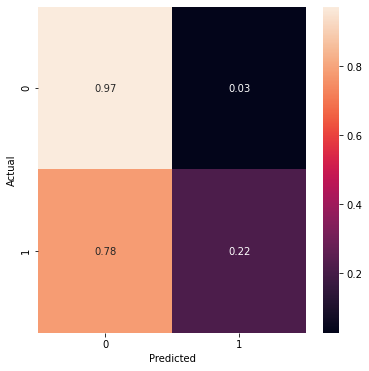

In [104]:
#confusion matrix
cm = confusion_matrix(sorted_weights_union["actual_values"].values , sorted_weights_union["predicted_values"].values)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [105]:
validation(initial_dataset['target'], sorted_weights_union["predicted_values"])

(415,
 500,
 138,
 12,
 0.5192488262910798,
 0.453551912568306,
 0.9718969555035128,
 0.6184798807749627)

### Synonyms for union

In [109]:
#increased dictionary with synonyms (weights from original words)
list_synonyms_union = []
for i in dictionary_union:
    for syn in wn.synsets(i): 
        for name in syn.lemma_names():
            list_synonyms_union.append((name, dictionary_union[i]))

list_important_synonyms_union = []
for x in list_synonyms_union:
    if x[0] not in dictionary_union.keys():
        if x[1]> 0.5:
            list_important_synonyms_union.append((x[0], x[1]))
list_important_synonyms_union

for x in list_important_synonyms_union:
    dictionary_union [x[0]] = x[1]
dictionary_union_syn = dictionary_union
dictionary_union_syn

{'goatfucker': 0.8227534110922157,
 'shit': 0.34383824267544094,
 'fucking': 0.4641372044868458,
 'retard': 0.3322861957967228,
 'fuck': 0.5749903436633833,
 'idiot': 0.3909372869265523,
 'piece': 0.19653841057121108,
 'piece_shit': 0.13360350077956692,
 'asshole': 0.2513566232544929,
 'cunt': 0.2281233100573559,
 'worthless': 0.1354308825572221,
 'ass': 0.027077660022453293,
 'bitch': 0.24687870642650356,
 'care': 0.08018264463090953,
 'know': 0.08709729955011872,
 'loser': 0.023802479429188023,
 'fucking_fucking': 0.009210436856880375,
 'dumbass': 0.20084438785762182,
 'pathetic': 0.11517699112855852,
 'say': 0.11847438752357167,
 'get': 0.14099735090154353,
 'realdonaldtrump': 0.11291064901127207,
 "'re": 0.02131314522680905,
 'dumb': 0.01253344952592003,
 'stupid': 0.0372803092646869,
 'people': 0.00015853781508406994,
 'guess': 0.010095384247886544,
 'fag': 0.2123757657595436,
 'good': 0.01118886906457992,
 'don?t_nazi': 0.0,
 'libtard': 0.21777309849451282,
 'pussy': 0.2229734247